# Spectrum Kernel Development
Described in Slides 341 -> 344.

In [ ]:
%reset

In [1]:
import os
os.chdir('../')

from data_handler import *
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pdb

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

# Create Spectrum Kernel functions

In [2]:
%run data_handler.py

In [3]:
%run kernels.py

In [4]:
%run kernel_methods.py

In [5]:
data = load_data(1, 'tr')

substring_length = 3
dictionary = create_dictionary(data['Sequence'], substring_length)

seq_A = data['Sequence'][0]
seq_B = data['Sequence'][2]

spetrum_kernel(seq_A, seq_B, substring_length, dictionary, False)

95

Loading the datasets...

In [6]:
#Charge training data and create training vocabulary
tr0 = load_data(0, 'tr')
tr1 = load_data(1, 'tr')
tr2 = load_data(2, 'tr')
tr = pd.concat([tr0,tr1,tr2])

## Loading test data
te0 = load_data(0, 'te')
te1 = load_data(1, 'te')
te2 = load_data(2, 'te')

# Kernel SVM with spectrum kernel

Spectrum kernel attributes

In [9]:
substring_length = 6
dictionary = create_dictionary(tr['Sequence'], substring_length)
ind2word = {idx: word for word,idx in dictionary.items()}

# Creating feature vectors
features_tr0 = np.apply_along_axis(lambda seq_A: create_occ_feature(seq_A[0], substring_length, dictionary, False), axis=1, arr=tr0['Sequence'].as_matrix().reshape(2000,1))
features_tr1 = np.apply_along_axis(lambda seq_A: create_occ_feature(seq_A[0], substring_length, dictionary, False), axis=1, arr=tr1['Sequence'].as_matrix().reshape(2000,1))
features_tr2 = np.apply_along_axis(lambda seq_A: create_occ_feature(seq_A[0], substring_length, dictionary, False), axis=1, arr=tr2['Sequence'].as_matrix().reshape(2000,1))

# Creating feature vectors
features_te0 = np.apply_along_axis(lambda seq_A: create_occ_feature(seq_A[0], substring_length, dictionary, False), axis=1, arr=te0['Sequence'].as_matrix().reshape(1000,1))
features_te1 = np.apply_along_axis(lambda seq_A: create_occ_feature(seq_A[0], substring_length, dictionary, False), axis=1, arr=te1['Sequence'].as_matrix().reshape(1000,1))
features_te2 = np.apply_along_axis(lambda seq_A: create_occ_feature(seq_A[0], substring_length, dictionary, False), axis=1, arr=te2['Sequence'].as_matrix().reshape(1000,1))

Normalizing data + adding offset column

In [ ]:
features_tr0 = data_normalization(features_tr0, offset_column=False)
features_tr1 = data_normalization(features_tr1, offset_column=False)
features_tr2 = data_normalization(features_tr2, offset_column=False)

features_te0 = data_normalization(features_te0, offset_column=False)
features_te1 = data_normalization(features_te1, offset_column=False)
features_te2 = data_normalization(features_te2, offset_column=False)

Kernel SVM attributes

In [ ]:
lbda = 0.014

In [ ]:
### Kernel SVM - Linear from features ###
kSVM = kernelSVM(lbda)

#Train
kSVM.train(features_tr0, 
         tr0['Bound'].as_matrix(), 
         stringsData=False)

#Test
predictions = kSVM.predict(features_te0, stringsData=False)

In [ ]:
## Running 4-fold cross-validation to assess performance on an arbitrary lambda

tr0_assessment = kSVM.assess(
    features_tr0, 
    tr0['Bound'].as_matrix(),
    n_folds=4,
    stringsData=False,
    verbose=False
)

In [ ]:
## Running a grid-search to assess the best value for lambda

kSVM0_grid = kSVM.grid_search(
    features_tr0,
    tr0['Bound'].as_matrix(), 
    search_min = 0.00001,
    search_max = 1,
    search_count = 8,
    n_folds = 5,
    scale='log'
)

kSVM1_grid = kSVM.grid_search(
    features_tr1,
    tr1['Bound'].as_matrix(), 
    search_min = 0.00001,
    search_max = 1,
    search_count = 8,
    n_folds = 5,
    scale='log'
)

kSVM2_grid = kSVM.grid_search(
    features_tr2,
    tr2['Bound'].as_matrix(), 
    search_min = 0.00001,
    search_max = 1,
    search_count = 8,
    n_folds = 5,
    scale='log'
)

In [ ]:
kSVM0_grid

In [ ]:
kSVM1_grid

In [ ]:
kSVM2_grid

In [ ]:
## Comparing performances to the SciKit-learn SVC
from sklearn.svm import SVC
from sklearn.model_selection import KFold

lbda = 0.014
C = 1.0/lbda
svc = SVC(C, kernel='linear')

kf = KFold(n_splits=6)

X0 = features_tr0
y0 = tr0['Bound'].as_matrix()

scores=[]

for train_index, test_index in kf.split(X0):
    X_train, X_test = X0[train_index], X0[test_index]
    y_train, y_test = y0[train_index], y0[test_index]
    svc.fit(X_train, y_train)
    scores.append(svc.score(X_test,y_test))

This fairly much proves that our SVM works as much as the one from SciKit...

In [ ]:
lbda = 0.03
kSVM.lbda = lbda

kSVM.train(features_tr0, tr0['Bound'].as_matrix())
kSVM_te0_raw = kSVM.classify(kSVM.predict(features_te0))
kSVM_te0 = pd.DataFrame(
    data = format_preds(kSVM_te0_raw),
    columns = ['Bound'])

kSVM.train(features_tr1, tr1['Bound'].as_matrix())
kSVM_te1_raw = kSVM.classify(kSVM.predict(features_te1))
kSVM_te1 = pd.DataFrame(
    data = format_preds(kSVM_te1_raw),
    columns = ['Bound'])
kSVM_te1.index = kSVM_te1.index + 1000

kSVM.train(features_tr2, tr2['Bound'].as_matrix())
kSVM_te2_raw = kSVM.classify(kSVM.predict(features_te2))
kSVM_te2 = pd.DataFrame(
    data = format_preds(kSVM_te2_raw),
    columns = ['Bound'])
kSVM_te2.index = kSVM_te2.index + 2000

frames = [kSVM_te0, kSVM_te1, kSVM_te2]
kSVM_te = pd.concat(frames)
kSVM_te.index = kSVM_te.index.set_names(['Id'])

kSVM_te.to_csv('predictions/kSVM33_spectrumKernel_te.csv')

# KernelSVM with mismatch kernel

In [ ]:
alphabet = ['A', 'C', 'G', 'T']
substring_length = 5
mismatch_tol = 1

vocab2index, _ = create_vocab(alphabet, substring_length)
neighbours = compute_neighbours(vocab2index, mismatch_tol)

# Creating mismatch kernels train feature vectors
features_tr0 = np.zeros((len(tr0), len(vocab2index)))
for idx, seq in enumerate(tr0['Sequence']):
    features_tr0[idx, :] = create_mismatch_feature(seq, substring_length, vocab2index, neighbours, normalize=False)

features_tr1 = np.zeros((len(tr1), len(vocab2index)))
for idx, seq in enumerate(tr1['Sequence']):
    features_tr1[idx, :] = create_mismatch_feature(seq, substring_length, vocab2index, neighbours, normalize=False)

features_tr2 = np.zeros((len(tr2), len(vocab2index)))
for idx, seq in enumerate(tr2['Sequence']):
    features_tr2[idx, :] = create_mismatch_feature(seq, substring_length, vocab2index, neighbours, normalize=False)
    
# Creating mismatch kernels test feature vectors
features_te0 = np.zeros((len(te0), len(vocab2index)))
for idx, seq in enumerate(te0['Sequence']):
    features_te0[idx, :] = create_mismatch_feature(seq, substring_length, vocab2index, neighbours, normalize=False)

features_te1 = np.zeros((len(te1), len(vocab2index)))
for idx, seq in enumerate(te1['Sequence']):
    features_te1[idx, :] = create_mismatch_feature(seq, substring_length, vocab2index, neighbours, normalize=False)

features_te2 = np.zeros((len(te2), len(vocab2index)))
for idx, seq in enumerate(te2['Sequence']):
    features_te2[idx, :] = create_mismatch_feature(seq, substring_length, vocab2index, neighbours, normalize=False)

Features normalization layer

In [ ]:
features_tr0 = data_normalization(features_tr0, offset_column=True)
features_tr1 = data_normalization(features_tr1, offset_column=True)
features_tr2 = data_normalization(features_tr2, offset_column=True)

features_te0 = data_normalization(features_te0, offset_column=True)
features_te1 = data_normalization(features_te1, offset_column=True)
features_te2 = data_normalization(features_te2, offset_column=True)

In [ ]:
## Running a grid-search to assess the best value for lambda
lbda = 0.03
kSVM_mm = kernelSVM(lbda)

kSVM0_grid = kSVM_mm.grid_search(
    features_tr0,
    tr0['Bound'].as_matrix(), 
    search_min = 0.0001,
    search_max = 100,
    search_count = 7,
    scale='log'
)

kSVM1_grid = kSVM_mm.grid_search(
    features_tr1,
    tr1['Bound'].as_matrix(), 
    search_min = 0.0001,
    search_max = 100,
    search_count = 7,
    scale='log'
)

kSVM2_grid = kSVM_mm.grid_search(
    features_tr2,
    tr2['Bound'].as_matrix(), 
    search_min = 0.0001,
    search_max = 100,
    search_count = 7,
    scale='log'
)

In [ ]:
kSVM0_grid

In [ ]:
kSVM1_grid

In [ ]:
kSVM2_grid

In [ ]:
lbda = 1
kSVM.lbda = lbda

kSVM.train(features_tr0, tr0['Bound'].as_matrix())
kSVM_te0_raw = kSVM.classify(kSVM.predict(features_te0))
kSVM_te0 = pd.DataFrame(
    data = format_preds(kSVM_te0_raw),
    columns = ['Bound'])

kSVM.train(features_tr1, tr1['Bound'].as_matrix())
kSVM_te1_raw = kSVM.classify(kSVM.predict(features_te1))
kSVM_te1 = pd.DataFrame(
    data = format_preds(kSVM_te1_raw),
    columns = ['Bound'])
kSVM_te1.index = kSVM_te1.index + 1000

kSVM.train(features_tr2, tr2['Bound'].as_matrix())
kSVM_te2_raw = kSVM.classify(kSVM.predict(features_te2))
kSVM_te2 = pd.DataFrame(
    data = format_preds(kSVM_te2_raw),
    columns = ['Bound'])
kSVM_te2.index = kSVM_te2.index + 2000

frames = [kSVM_te0, kSVM_te1, kSVM_te2]
kSVM_te = pd.concat(frames)
kSVM_te.index = kSVM_te.index.set_names(['Id'])

kSVM_te.to_csv('predictions/kSVM1_mismatchKernel5_1_te.csv')

# Kernel kNN with spectrum kernel

In [ ]:
### Kernel NN - Linear from features ###
k = 1
kNN = kernelKNN(k)

In [ ]:
kNN.train(features_tr0, tr0['Bound'].as_matrix())
kNN_te0_raw = kNN.predict(features_te0)
kNN_te0 = pd.DataFrame(
    data = format_preds(kNN_te0_raw),
    columns = ['Bound'])

kNN.train(features_tr1, tr1['Bound'].as_matrix())
kNN_te1_raw = kNN.predict(features_te1)
kNN_te1 = pd.DataFrame(
    data = format_preds(kNN_te1_raw),
    columns = ['Bound'])
kNN_te1.index = kNN_te1.index + 1000

kNN.train(features_tr2, tr2['Bound'].as_matrix())
kNN_te2_raw = kNN.predict(features_te2)
kNN_te2 = pd.DataFrame(
    data = format_preds(kNN_te2_raw),
    columns = ['Bound'])
kNN_te2.index = kNN_te2.index + 2000

frames = [kNN_te0, kNN_te1, kNN_te2]
kNN_te = pd.concat(frames)
kNN_te.index = kNN_te.index.set_names(['Id'])

kNN_te.to_csv('predictions/kNN10_spectralKernel_te.csv')

In [ ]:
### Kernel NN - Linear from features ###
k = 1
kNN = kernelKNN(k)
kNN.assess(features_tr0, tr0['Bound'].as_matrix(), n_folds=5, stringsData=False)

In [ ]:
kNN.assess(features_tr1, tr1['Bound'].as_matrix(), n_folds=5, stringsData=False)

In [ ]:
kNN.assess(features_tr2, tr2['Bound'].as_matrix(), n_folds=5, stringsData=False)

# Mutual information criterion on string features

In [10]:
def get_MI(data, labels, word_idx, bins):
    n,p = data.shape
    idx_bound = np.argwhere(labels==1)
    idx_unbound = np.argwhere(labels==0)
    data_bound = np.take(data, idx_bound, axis=0)
    data_unbound = np.take(data, idx_unbound, axis=0)
    
    n_b = len(data_bound)
    n_ub = n - n_b
    data_bound = data_bound.reshape((n_b,p))
    data_unbound = data_unbound.reshape((n_ub,p))
    
    p_b = n_b*1.0/n
    p_ub = 1.0 - p_b
    
    MI = 0
    for abin in bins:
        b_cond = np.count_nonzero(np.isin(data_bound[:,word_idx], abin))*1.0/n_b
        ub_cond= np.count_nonzero(np.isin(data_unbound[:,word_idx], abin))*1.0/n_ub

        cond_data = np.isin(data[:,word_idx], abin)
        n_cond = np.count_nonzero(cond_data)
        if n_cond == 0:
            continue
        cond_b = np.count_nonzero(labels[cond_data]==1)*1.0/n_cond
        cond_ub = 1.0 - cond_b       
    
        if cond_b > 0:
            MI = MI + b_cond*p_b*np.log(cond_b/p_b)
        if cond_ub > 0:
            MI = MI + ub_cond*p_ub*np.log(cond_ub/p_ub)
        if np.isnan(MI):
            pdb.set_trace()
    return MI

def argmax_MI(data, labels, n_feats, bins):
    n,p = data.shape
    MI = np.zeros(p)
    for word_idx in range(p):
        MI[word_idx] = get_MI(data, labels, word_idx, bins)
    max_MI_idx = np.argsort(MI)[-1:-(n_feats+2):-1]
    return max_MI_idx, MI[max_MI_idx]

def MI_dimRed(data, labels, n_feats, bins):
    idx, MI_ranked = argmax_MI(data, labels, n_feats-1, bins)
    data_lowdim = np.take(data, idx, axis=1)
    return data_lowdim, idx, MI_ranked

In [11]:
n_feats = 300
bins = [[0],[1],[2],range(3,6), range(6,12), range(12,30), range(30,101)]

ind2word = {idx: word for word,idx in dictionary.items()}

In [12]:
tr0_MIidx, tr0_MI_ranked = argmax_MI(features_tr0, tr0['Bound'].as_matrix(), n_feats, bins)
tr1_MIidx, tr1_MI_ranked = argmax_MI(features_tr1, tr1['Bound'].as_matrix(), n_feats, bins)
tr2_MIidx, tr2_MI_ranked = argmax_MI(features_tr2, tr2['Bound'].as_matrix(), n_feats, bins)

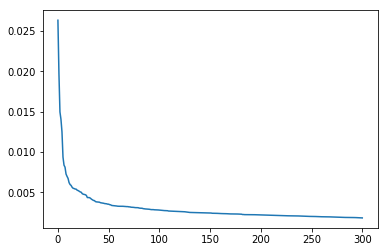

In [13]:
plt.plot(tr0_MI_ranked)

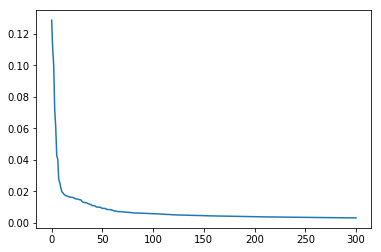

In [14]:
plt.plot(tr1_MI_ranked)

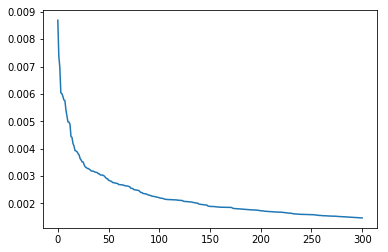

In [15]:
plt.plot(tr2_MI_ranked)

In [16]:
nf0 = 10
tr0_KWfeats, tr0_KWidx, _ = MI_dimRed(features_tr0, tr0['Bound'].as_matrix(), nf0, bins)

nf1 = 16
tr1_KWfeats, tr1_KWidx, _ = MI_dimRed(features_tr1, tr1['Bound'].as_matrix(), nf1, bins)

nf2 = 50
tr2_KWfeats, tr2_KWidx, _ = MI_dimRed(features_tr2, tr2['Bound'].as_matrix(), nf2, bins)

In [17]:
def gd_log_reg(data, labels, substring_length, dictionary, regularizations, penalties, normalize):
    max_score = 0
    max_model = None

    print('--Normalize: {0} - Substring Length: {1}'.format(normalize, substring_length))
    for penal in penalties:
        for regu in regularizations:
            clf = LogisticRegression(C = regu, penalty = penal)
            score = np.mean(cross_val_score(clf, data, labels, cv = 5))

            if score > max_score:
                max_score = score
                max_model = clf
                print('----Increase in Score. Penal: {0} - Regu: {1}. Mean Val Score: {2:.2f}'.format(penal, regu, 100*score))

In [18]:
regularizations = [0.001, 0.005, 0.01, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 2]
penalties = ['l1', 'l2']

In [19]:
gd_log_reg(tr0_KWfeats, tr0['Bound'].as_matrix(), substring_length, dictionary, regularizations, penalties, normalize=False)

--Normalize: False - Substring Length: 6
----Increase in Score. Penal: l1 - Regu: 0.001. Mean Val Score: 50.00
----Increase in Score. Penal: l1 - Regu: 0.05. Mean Val Score: 64.80
----Increase in Score. Penal: l1 - Regu: 0.075. Mean Val Score: 65.60
----Increase in Score. Penal: l1 - Regu: 0.1. Mean Val Score: 65.65
----Increase in Score. Penal: l1 - Regu: 0.25. Mean Val Score: 66.15
----Increase in Score. Penal: l1 - Regu: 0.5. Mean Val Score: 66.55
----Increase in Score. Penal: l1 - Regu: 0.75. Mean Val Score: 67.00
----Increase in Score. Penal: l2 - Regu: 0.001. Mean Val Score: 67.45
----Increase in Score. Penal: l2 - Regu: 2. Mean Val Score: 67.45


In [20]:
gd_log_reg(tr1_KWfeats, tr1['Bound'].as_matrix(), substring_length, dictionary, regularizations, penalties, normalize=False)

--Normalize: False - Substring Length: 6
----Increase in Score. Penal: l1 - Regu: 0.001. Mean Val Score: 50.00
----Increase in Score. Penal: l1 - Regu: 0.01. Mean Val Score: 71.50
----Increase in Score. Penal: l1 - Regu: 0.05. Mean Val Score: 79.25
----Increase in Score. Penal: l1 - Regu: 0.075. Mean Val Score: 80.60
----Increase in Score. Penal: l1 - Regu: 0.1. Mean Val Score: 80.80
----Increase in Score. Penal: l1 - Regu: 0.25. Mean Val Score: 81.05
----Increase in Score. Penal: l1 - Regu: 0.75. Mean Val Score: 81.10
----Increase in Score. Penal: l1 - Regu: 1. Mean Val Score: 81.20
----Increase in Score. Penal: l2 - Regu: 0.005. Mean Val Score: 81.30
----Increase in Score. Penal: l2 - Regu: 0.25. Mean Val Score: 81.45
----Increase in Score. Penal: l2 - Regu: 0.5. Mean Val Score: 81.50


In [21]:
gd_log_reg(tr2_KWfeats, tr2['Bound'].as_matrix(), substring_length, dictionary, regularizations, penalties, normalize=False)

--Normalize: False - Substring Length: 6
----Increase in Score. Penal: l1 - Regu: 0.001. Mean Val Score: 50.00
----Increase in Score. Penal: l1 - Regu: 0.05. Mean Val Score: 53.00
----Increase in Score. Penal: l1 - Regu: 0.075. Mean Val Score: 58.00
----Increase in Score. Penal: l1 - Regu: 0.1. Mean Val Score: 59.55
----Increase in Score. Penal: l1 - Regu: 0.25. Mean Val Score: 62.10
----Increase in Score. Penal: l1 - Regu: 0.5. Mean Val Score: 63.00
----Increase in Score. Penal: l2 - Regu: 0.001. Mean Val Score: 63.50
----Increase in Score. Penal: l2 - Regu: 0.05. Mean Val Score: 64.05


In [22]:
## Using high information strings from spectrum/mismatch as initial convolution patches

tr0_KW = [ind2word[idx] for idx in tr0_KWidx]
tr1_KW = [ind2word[idx] for idx in tr1_KWidx]
tr2_KW = [ind2word[idx] for idx in tr2_KWidx]

In [23]:
set(tr1_KW).intersection(set(tr2_KW))

set()

## Grid search on MLP

In [24]:
archis = [(10), (20), (25), (50), (75), (100)]
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

In [25]:
def gd_mlp(data, labels, substring_length, dictionary, archis, alphas, normalize):
    max_score = 0
    max_model = None

    print('--Normalize: {0} - Substring Length: {1}'.format(normalize, substring_length))
    for alpha in alphas:
        for archi in archis:
            clf = MLPClassifier(hidden_layer_sizes = archi, alpha = alpha,  max_iter = 1000)
            score = np.mean(cross_val_score(clf, data, labels, cv = 5))

            if score > max_score:
                max_score = score
                max_model = clf
                print('----Increase in Score. Regu: {0} - Archi: {1}. Mean Val Score: {2:.2f}'.format(alpha, archi, 100*score))

In [26]:
gd_mlp(tr0_KWfeats, tr0['Bound'].as_matrix(), substring_length, dictionary, archis, alphas, normalize= False)

--Normalize: False - Substring Length: 6
----Increase in Score. Regu: 0.001 - Archi: 10. Mean Val Score: 66.85
----Increase in Score. Regu: 0.001 - Archi: 20. Mean Val Score: 67.20
----Increase in Score. Regu: 0.005 - Archi: 20. Mean Val Score: 67.45
----Increase in Score. Regu: 0.05 - Archi: 100. Mean Val Score: 67.50


In [27]:
gd_mlp(tr1_KWfeats, tr1['Bound'].as_matrix(), substring_length, dictionary, archis, alphas, normalize= False)

--Normalize: False - Substring Length: 6
----Increase in Score. Regu: 0.001 - Archi: 10. Mean Val Score: 80.80
----Increase in Score. Regu: 0.001 - Archi: 20. Mean Val Score: 81.00
----Increase in Score. Regu: 0.001 - Archi: 25. Mean Val Score: 81.15
----Increase in Score. Regu: 0.001 - Archi: 50. Mean Val Score: 81.15
----Increase in Score. Regu: 0.05 - Archi: 20. Mean Val Score: 81.30
----Increase in Score. Regu: 0.1 - Archi: 50. Mean Val Score: 81.35
----Increase in Score. Regu: 1 - Archi: 20. Mean Val Score: 81.45


In [28]:
gd_mlp(tr2_KWfeats, tr2['Bound'].as_matrix(), substring_length, dictionary, archis, alphas, normalize= False)

--Normalize: False - Substring Length: 6
----Increase in Score. Regu: 0.001 - Archi: 10. Mean Val Score: 60.65
----Increase in Score. Regu: 0.005 - Archi: 10. Mean Val Score: 60.85
----Increase in Score. Regu: 0.01 - Archi: 10. Mean Val Score: 61.00


/home/proprietaire/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/proprietaire/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/proprietaire/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/proprietaire/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/proprietaire/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted b

----Increase in Score. Regu: 0.1 - Archi: 10. Mean Val Score: 62.15


/home/proprietaire/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/proprietaire/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/proprietaire/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/proprietaire/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


----Increase in Score. Regu: 0.5 - Archi: 10. Mean Val Score: 62.95
----Increase in Score. Regu: 0.5 - Archi: 100. Mean Val Score: 63.00
----Increase in Score. Regu: 1 - Archi: 10. Mean Val Score: 63.10
----Increase in Score. Regu: 1 - Archi: 100. Mean Val Score: 63.20


## Using those factor words as filters in convolutional layer

In [ ]:
from tqdm import tqdm

import keras
from keras import regularizers
from keras.layers import Activation, Conv1D, Dense, Dropout, Embedding, Flatten, Input, LSTM, MaxPooling1D
from keras.models import Model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model, np_utils
from keras.utils.vis_utils import model_to_dot
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import KFold, cross_val_score

seq_len = 101
nucl_map={'A':[1,0,0,0], 'C':[0,1,0,0], 'G':[0,0,1,0], 'T':[0,0,0,1]}
nb_conv = 10

seed = 9
np.random.seed(seed)

In [ ]:

# 1 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

def one_hot_batch(sequences, sep=" "):
    oh_seqs = []
    for seq in sequences:
        split_seq = seq.split(sep)
        oh_seq = [nucl_map[nucl] for nucl in split_seq]
        oh_seqs.append(oh_seq)
    return np.array(oh_seqs)

def split_seqs(sequences, split=" "):
    return [split.join(seq) for seq in sequences]

tr0_split = split_seqs(tr0['Sequence'].as_matrix().tolist())
tr0_oh = one_hot_batch(tr0_split)

tr1_split = split_seqs(tr1['Sequence'].as_matrix().tolist())
tr1_oh = one_hot_batch(tr1_split)

tr2_split = split_seqs(tr2['Sequence'].as_matrix().tolist())
tr2_oh = one_hot_batch(tr2_split)


te0_split = split_seqs(te0['Sequence'].as_matrix().tolist())
te0_oh = one_hot_batch(te0_split)

te1_split = split_seqs(te1['Sequence'].as_matrix().tolist())
te1_oh = one_hot_batch(te1_split)

te2_split = split_seqs(te2['Sequence'].as_matrix().tolist())
te2_oh = one_hot_batch(te2_split)

In [ ]:
## One-hot encodding of labels
tr0_oh_labels = np_utils.to_categorical(tr0['Bound'].as_matrix(), 2)
tr1_oh_labels = np_utils.to_categorical(tr1['Bound'].as_matrix(), 2)
tr2_oh_labels = np_utils.to_categorical(tr2['Bound'].as_matrix(), 2)

In [ ]:
## Tokenization of key-words
tr0_KW_oh = one_hot_batch(tr0_KW)
tr1_KW_oh = one_hot_batch(tr1_KW)
tr2_KW_oh = one_hot_batch(tr2_KW)

## Using high information strings from spectrum/mismatch as initial convolution patches
from keras import backend as K

def my_init(shape, dtype=None):
    pdb.set_trace()
    if shape != substring_length:
        return K.random_normal(shape, dtype=dtype)
    else:
        return 

model.add(Dense(64, kernel_initializer=my_init))